# Introduction
The dataset, hospitaldata.csv, contains 101,763 rows and 47 columns representing various patient-related information in a hospital setting. The data includes both numerical and categorical variables, covering aspects such as patient demographics, medical history, diagnosis, treatments, and outcomes.

Objective of the Analysis
find the best suited Logistic Regression model for the readmission of patients 
undergoing diabetes related treatment in a hospital.. This model will help understand the key factors influencing the target outcome and provide insights into the relationships between different variables.

Overview of Methodology

The methodology involves the following steps:

- Performing descriptive statistical analysis to summarize the key characteristics of the dataset.
- Using data visualizations to explore patterns and relationships between variables.
- Identifying the dependent variable and its relationship with independent variables.
- Building multiple regression models through feature selection, transformation, and diagnostic checks.
- Evaluating model performance using appropriate metrics to select the final regression model.
- Interpreting the final model to highlight the most influential predictors and their impact on the outcome.

# 1. Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, classification_report, roc_curve,

# 2. Data Import & Summary

In [5]:
data = pd.read_csv('hospitaldata.csv')

### 2.1 Data Overview

In [7]:
print("Initial data shape:", data.shape)

Initial data shape: (101763, 47)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 47 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101763 non-null  int64 
 1   patient_nbr               101763 non-null  int64 
 2   race                      101763 non-null  object
 3   gender                    101763 non-null  object
 4   age                       101763 non-null  object
 5   weight                    101763 non-null  object
 6   discharge_disposition_id  101763 non-null  object
 7   admission_source_id       101763 non-null  object
 8   time_in_hospital          101763 non-null  int64 
 9   medical_specialty         101763 non-null  object
 10  num_lab_procedures        101763 non-null  int64 
 11  num_procedures            101763 non-null  int64 
 12  num_medications           101763 non-null  int64 
 13  number_outpatient         101763 non-null  int64 
 14  numb

In [9]:
data.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017630e+05,1.017630e+05,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,1.652008e+08,5.432965e+07,4.396018,43.095909,1.339691,16.021835,0.369368,0.197842,0.635585,7.422649
std,1.026410e+08,3.869658e+07,2.985092,19.674220,1.705792,8.127589,1.267282,0.930485,1.262877,1.933578
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.495975e+07,2.341296e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523883e+08,4.550049e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302698e+08,8.754571e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


# 3. Exploratory Data Analysis (Pre-Cleaning)

#### 3.1 Understanding Target Variable (readmitted)

readmitted
No              54861
After30Days     35545
Within30Days    11357
Name: count, dtype: int64


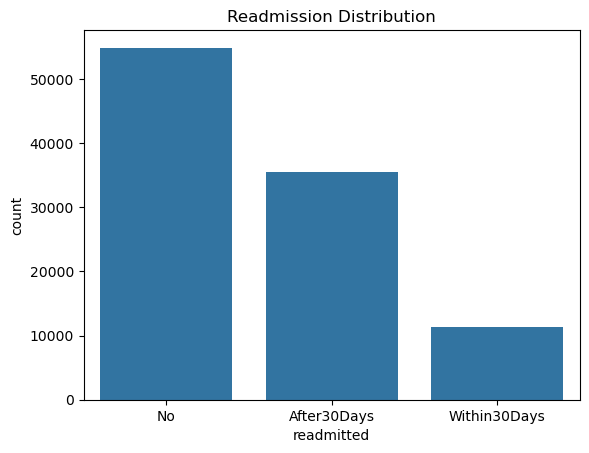

In [12]:
# Check unique values and their counts
print(data['readmitted'].value_counts())

# Distribution of the target variable
sns.countplot(x='readmitted', data=data)
plt.title('Readmission Distribution')
plt.show()

Combining the categories in readmitted column
- Within30days and After30days --> Readmitted
- No  --> Not Readmitted

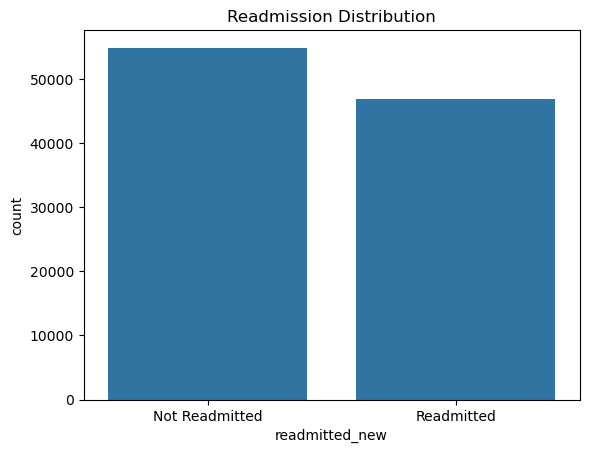

In [14]:
data["readmitted_new"] = data["readmitted"].apply(lambda x: "Readmitted" if x in ["Within30Days", "After30Days"] else "Not Readmitted")
sns.countplot(x='readmitted_new', data=data)
plt.title('Readmission Distribution')
plt.show()

In [15]:
data["readmitted_new"].value_counts()

readmitted_new
Not Readmitted    54861
Readmitted        46902
Name: count, dtype: int64

#### 3.2 Univariate Analysis

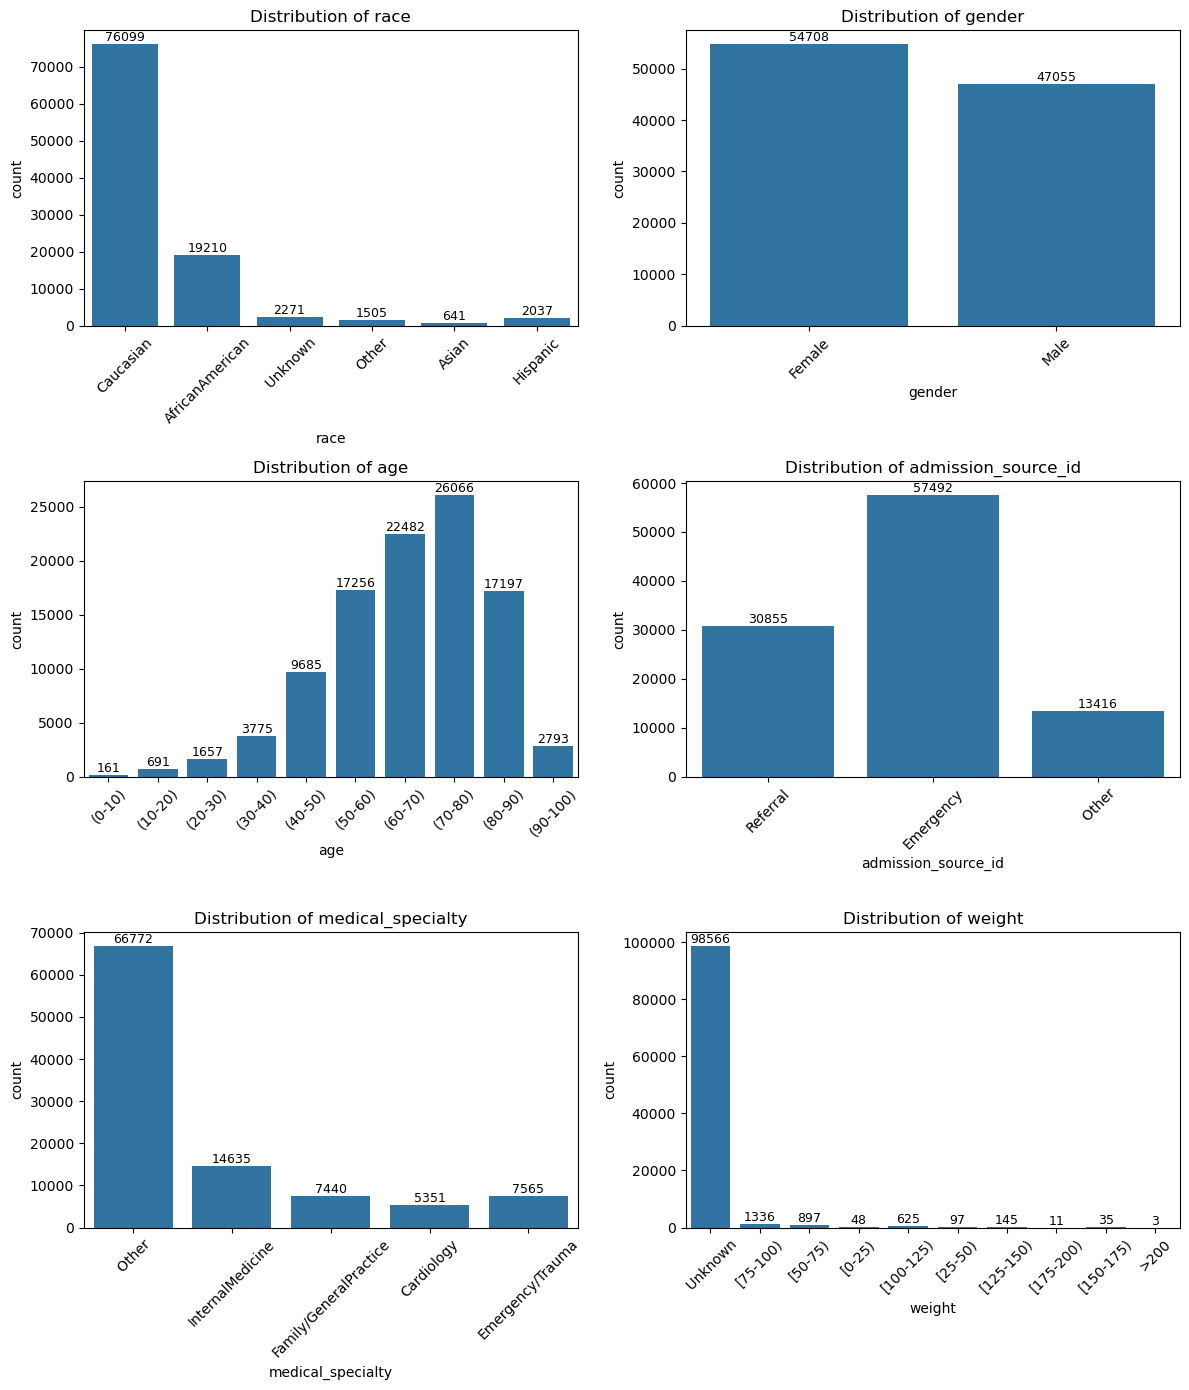

In [17]:
cols = ['race', 'gender', 'age', 'admission_source_id', 'medical_specialty', 'weight']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.countplot(ax=axes[i], x=col, data=data)
    
    # Add counts on bars
    for p in axes[i].patches:
        count = int(p.get_height())
        axes[i].annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='bottom', fontsize=9)
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### 3.3 Bivariate Analysis
how individual features relate to the target variable "readmitted".

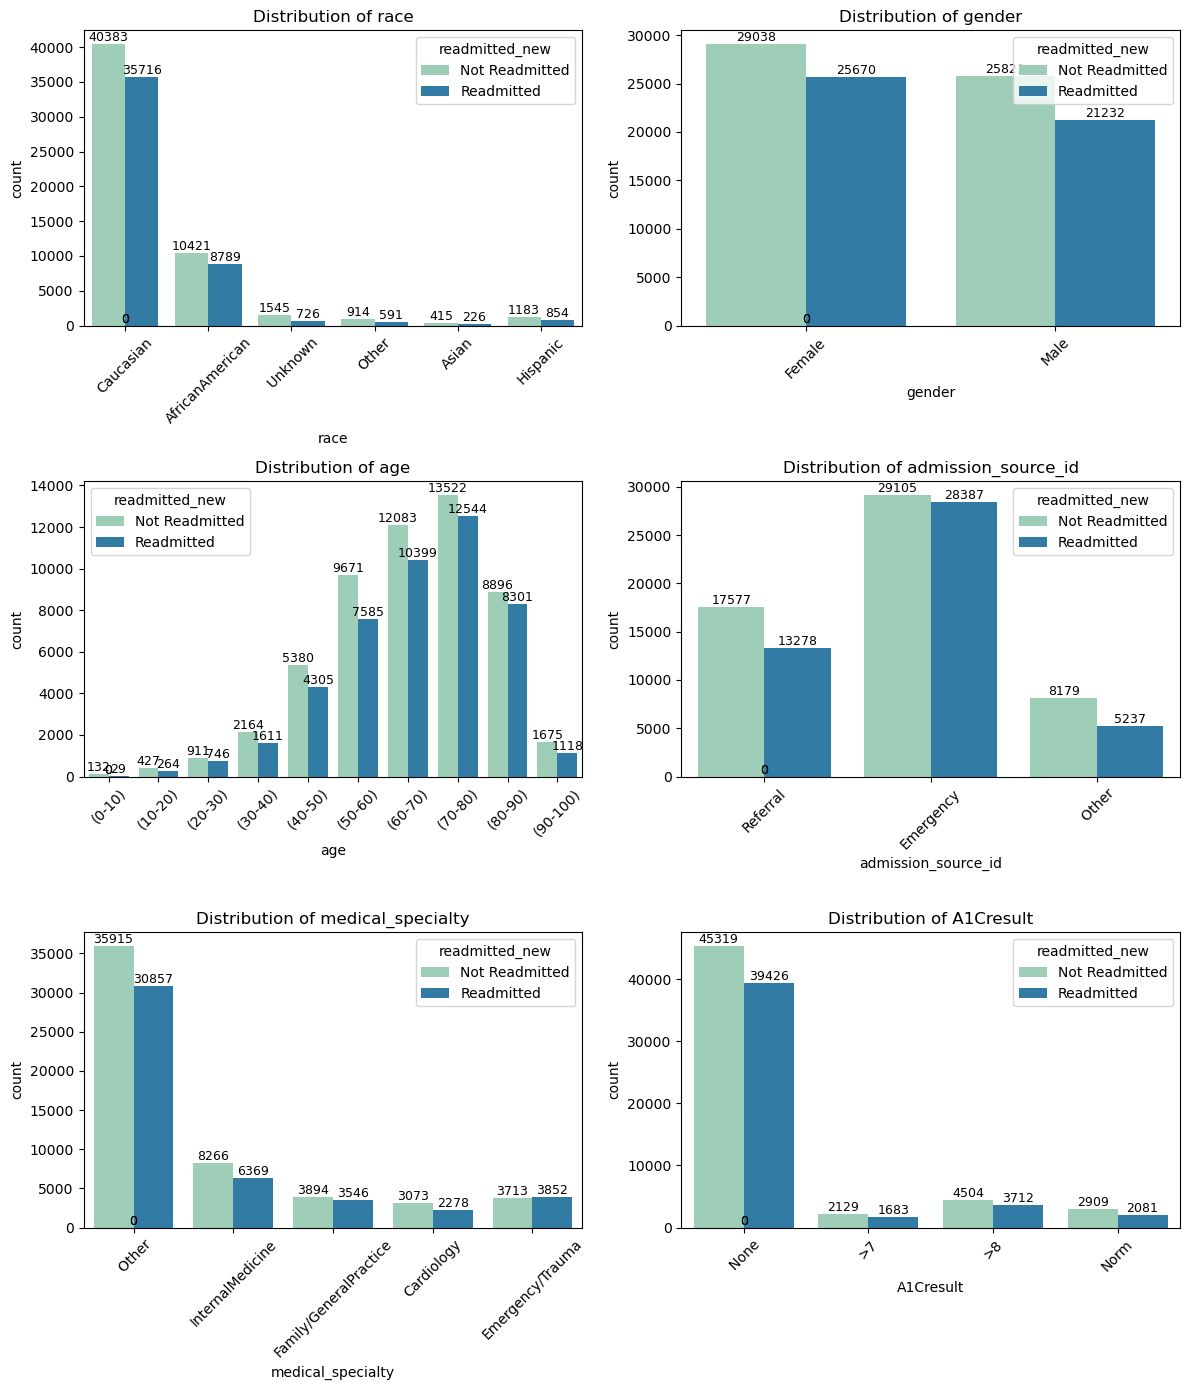

In [19]:
cols = ['race', 'gender', 'age', 'admission_source_id', 'medical_specialty', 'A1Cresult']

# Create a 2-row, 3-column grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.countplot(x=col, hue='readmitted_new',data=data, ax=axes[i], palette='YlGnBu')
    
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Adding index (count) labels on top of bars
    for p in axes[i].patches:
        count = int(p.get_height())
        axes[i].annotate(count, (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9)

# Remove the empty subplot (since 2x3 = 6 slots but only 5 plots)
if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

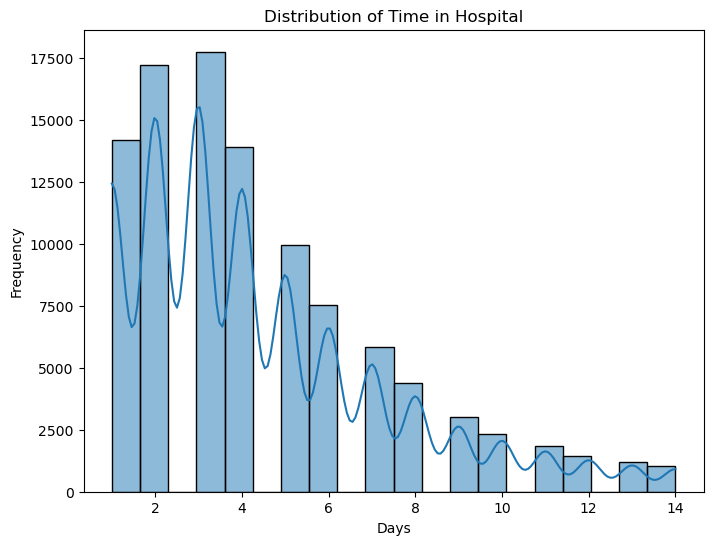

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(data['time_in_hospital'], bins=20, kde=True)
plt.title('Distribution of Time in Hospital')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

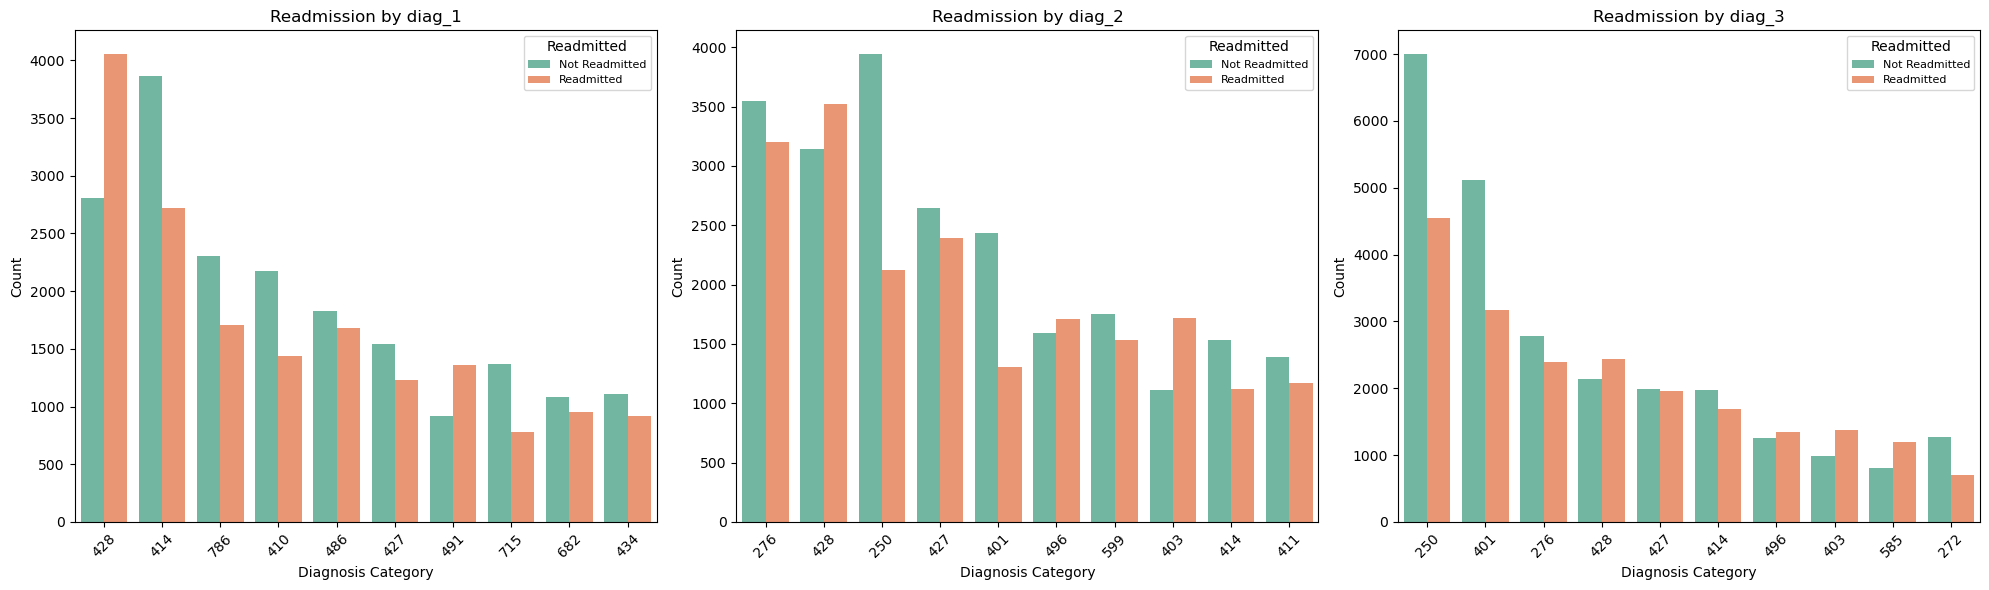

In [21]:
diagnosis_cols = ["diag_1", "diag_2", "diag_3"]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col in zip(axes, diagnosis_cols):
    sns.countplot(
        ax=ax, 
        x=col, 
        hue="readmitted_new", 
        data=data, 
        order=data[col].value_counts().index[:10],  # Optional: limit to top 10 most common diagnoses for better readability
        palette="Set2"
    )
    ax.set_title(f"Readmission by {col}", fontsize=12)
    ax.set_xlabel("Diagnosis Category", fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Readmitted', loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

#### 3.4 Correlation Heatmap

##### 3.4.1 Heatmap of Numerical Variables

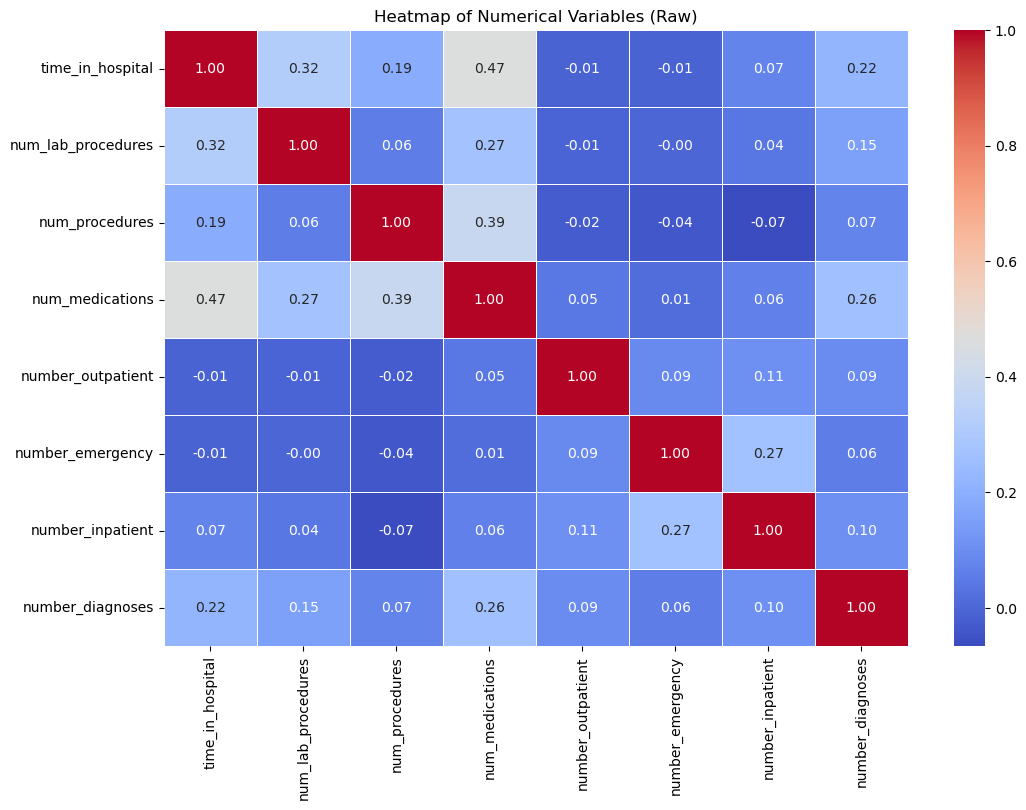

In [24]:
plt.figure(figsize=(12, 8))
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
corr_matrix = data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Numerical Variables (Raw)')
plt.show()

##### 3.4.2 Heatmap of Categorical Variables

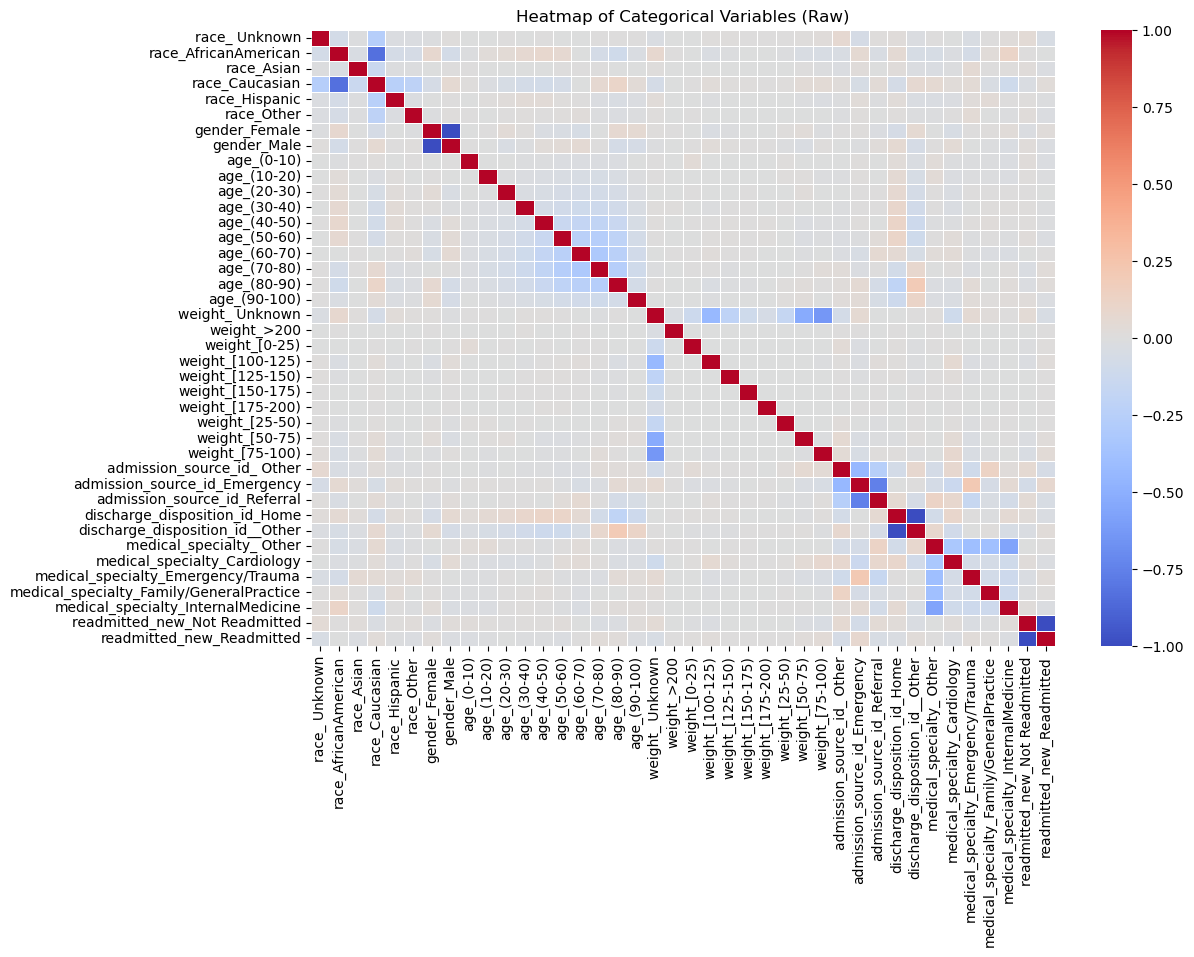

In [26]:
plt.figure(figsize=(12, 8))
categorical_cols = ['race', 'gender', 'age', 'weight', 'admission_source_id', 'discharge_disposition_id', 'medical_specialty', 'readmitted_new']
df_encoded = pd.get_dummies(data[categorical_cols])
corr_cat = df_encoded.corr()
sns.heatmap(corr_cat, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Categorical Variables (Raw)')
plt.show()

# 4. Data Cleaning & Preprocessing

#### 4.1 Handling Missing Values

In [29]:
# Replace "?" with NaN for easier handling
data.replace("?", pd.NA, inplace=True)

# Check missing values
missing_values = data.isnull().sum()
missing_values[missing_values > 0]

diag_1      21
diag_2     358
diag_3    1423
dtype: int64

#### 4.2 Removing Exrta White Space

In [31]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].map(lambda x: x.strip() if isinstance(x, str) else x)

#### 4.3 Calculating spaceholder
-	Unknown
-	None
-	Other
-	NaN

Calculating Unknown Counts

In [34]:
unknown = (data == "Unknown").sum()
unknown = unknown[unknown > 0]
unknown_percent = (unknown / len(data)) * 100

print("Total Unknown:")
print(pd.concat([unknown, unknown_percent.round(2)], axis=1, keys=["Count", "Percent"]))

Total Unknown:
        Count  Percent
race     2271     2.23
weight  98566    96.86


Calculating None Counts

In [36]:
nan = (data == "None").sum()
nan = nan[nan > 0]
nan_percent = (nan / len(data)) * 100

print("Total None:")
print(pd.concat([nan, nan_percent.round(2)], axis=1, keys=["Count", "Percent"]))


Total None:
               Count  Percent
max_glu_serum  96417    94.75
A1Cresult      84745    83.28


Calculating Other Counts

In [38]:
other = (data == "Other").sum()
other = other[other > 0]
other_percent = (other / len(data)) * 100
print("Total other Counts:")
print(pd.concat([nan, nan_percent.round(2)], axis=1, keys=["Count", "Percent"]))

Total other Counts:
               Count  Percent
max_glu_serum  96417    94.75
A1Cresult      84745    83.28


Calculating NaN Counts

In [40]:
Nan_counts = data.isna().sum()
print("Total Nan Counts:")
Nan_counts[Nan_counts > 0]

Total Nan Counts:


diag_1      21
diag_2     358
diag_3    1423
dtype: int64

### 4.4 Data Transformation 

#### 4.4.1 Transforming the Diagnostics column

In [43]:
def diagnosis(code):
    """
    Categorizes a diagnosis code into broader disease categories, 
    including specific categories for V and E codes.
    """
    try:
        if isinstance(code, str):
            if code.startswith("V"):
                return "Preventive Care"  # V codes = factors influencing health status
            elif code.startswith("E"):
                return "External Injury"  # E codes = external causes like accidents
            elif code.startswith("250."):
                return "Diabetes"
            code = float(code) if '.' in code else int(code)

        #code = float(code)  # handle numeric codes
        
        if 800 <= code <= 999:
            return "Injury and Poisoning"
        elif 780 <= code <= 799:
            return "Congenital Anomalies"
        elif 740 <= code <= 759:
            return "Symptoms and signs"
        elif 710 <= code <= 739:
            return "Diseases of the Musculoskeletal System"
        elif 680 <= code <= 709:
            return "Diseases of the Genitourinary System"
        elif 630 <= code <= 679:
            return "Complications of Pregnancy"   
        elif 580 <= code <= 629:
            return "Diseases of the Musculoskeletal System"
        elif 520 <= code <= 579:
            return "Diseases of the Digestive System"   
        elif 460 <= code <= 519:
            return "Diseases of the Respiratory System"
        elif 390 <= code <= 459:
             return "Diseases of the Circulatory System"
        elif 320 <= code <= 389:
             return "Diseases of the Nervous System"
        elif 290 <= code <= 319:
            return "Mental Disorders"
        elif 280 <= code <= 289:
            return "Diseases of the Blood "
        elif 240 <= code <= 279:
            return "Immunity Disorders"
        elif 140 <= code <= 239:
            return "Neoplasms"
        elif 1 <= code <= 139:
            return "Infectious and Parasitic Diseases"
        else:
            return "Other"
    except:
        return "Other"
        
for diag in ["diag_1", "diag_2", "diag_3"]:
    data[f"{diag}_new"] = data[diag].apply(diagnosis)



In [44]:
data['diag_1_new'].value_counts()

diag_1_new
Diseases of the Circulatory System        30335
Diseases of the Respiratory System        10407
Diseases of the Musculoskeletal System    10035
Diseases of the Digestive System           9208
Diabetes                                   8522
Congenital Anomalies                       7636
Injury and Poisoning                       6972
Neoplasms                                  3433
Immunity Disorders                         2937
Infectious and Parasitic Diseases          2768
Diseases of the Genitourinary System       2530
Mental Disorders                           2262
Preventive Care                            1644
Diseases of the Nervous System             1211
Diseases of the Blood                      1103
Complications of Pregnancy                  687
Symptoms and signs                           51
Other                                        21
External Injury                               1
Name: count, dtype: int64

In [45]:
for diag in ["diag_1_new", "diag_2_new", "diag_3_new"]:
    print(f"{diag} - % of 'Other':", (data[diag] == "Other").mean() * 100)


diag_1_new - % of 'Other': 0.020636184074761945
diag_2_new - % of 'Other': 0.35179780470308464
diag_3_new - % of 'Other': 1.3983471399231548


#### 4.4.2 Binning the Age column

In [47]:
# Check the distribution of valid age values
print(data['age'].value_counts())

age
(70-80)     26066
(60-70)     22482
(50-60)     17256
(80-90)     17197
(40-50)      9685
(30-40)      3775
(90-100)     2793
(20-30)      1657
(10-20)       691
(0-10)        161
Name: count, dtype: int64


In [48]:
# Create a mapping from age category to the midpoint value
age_mapping = {
    '(0-10)': 5,
    '(10-20)': 15,
    '(20-30)': 25,
    '(30-40)': 35,
    '(40-50)': 45,
    '(50-60)': 55,
    '(60-70)': 65,
    '(70-80)': 75,
    '(80-90)': 85,
    '(90-100)': 95
}
data['age_new'] = data['age'].map(age_mapping)

#### 4.4.3 Mapping the A1Cresult column

In [50]:
data['A1Cresult'].value_counts()

A1Cresult
None    84745
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64

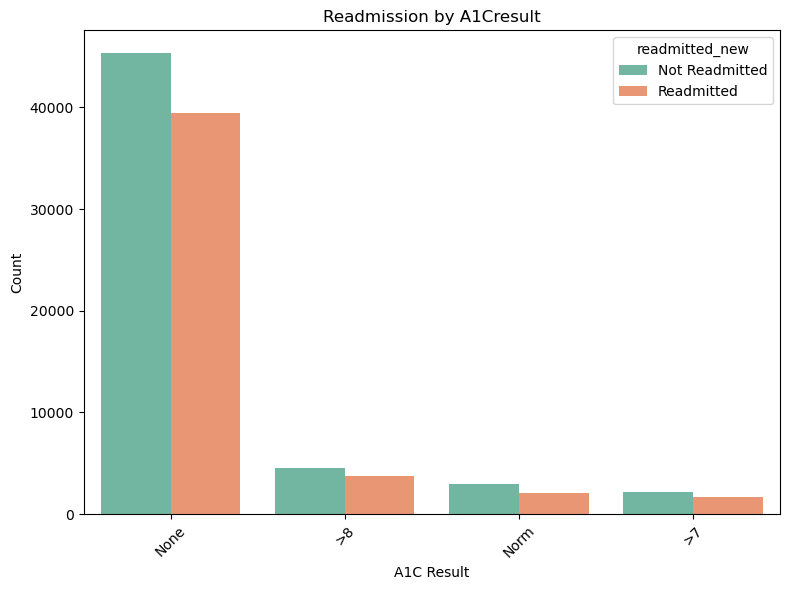

In [51]:
plt.figure(figsize=(8, 6))

sns.countplot(
    x='A1Cresult', 
    hue="readmitted_new", 
    data=data, 
    order=data['A1Cresult'].value_counts().index,
    palette="Set2"
)

plt.title("Readmission by A1Cresult")
plt.xlabel("A1C Result")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 

In [53]:
A1C_mapping = {"None": -1,"Norm": 0, ">7": 1, ">8": 2}
data['A1Cresult_value'] = data['A1Cresult'].map(A1C_mapping).fillna(-1)
data['A1Cresult_value'].value_counts()

A1Cresult_value
-1    84745
 2     8216
 0     4990
 1     3812
Name: count, dtype: int64

#### 4.4.4 Mapping the max_glu_serum Column

In [55]:
data['max_glu_serum'].value_counts()

max_glu_serum
None    96417
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64

In [56]:
# Mapped test result: valid only for those who took the test; NaN (or a placeholder) for "None"
max_glu_mapping = {"None": -1 ,"Norm": 0, ">200": 1, ">300": 2}
data['max_glu_serum_value'] = data['max_glu_serum'].map(max_glu_mapping)
data['max_glu_serum_value'].value_counts()

max_glu_serum_value
-1    96417
 0     2597
 1     1485
 2     1264
Name: count, dtype: int64

# 5 Feature Engineering 

#### 5.1 Creating Total Visits

In [59]:
data['total_visits'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']

#### 5.2 Create a 'polypharmacy' feature

In [61]:
data['polypharmacy'] = data['num_medications'].apply(lambda x: 1 if x > 10 else 0)

# 6 Exploratory Data Analysis (Post-Cleaning)

#### 6.1 Re-check Target Variable Distribution

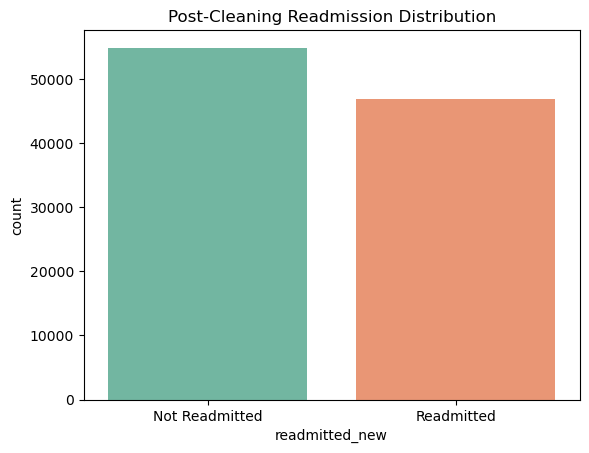

In [64]:
sns.countplot(x='readmitted_new', hue ='readmitted_new', data=data, palette='Set2')
plt.title('Post-Cleaning Readmission Distribution')
plt.show()


####  6.2 Univariate Analysis on Engineered Features

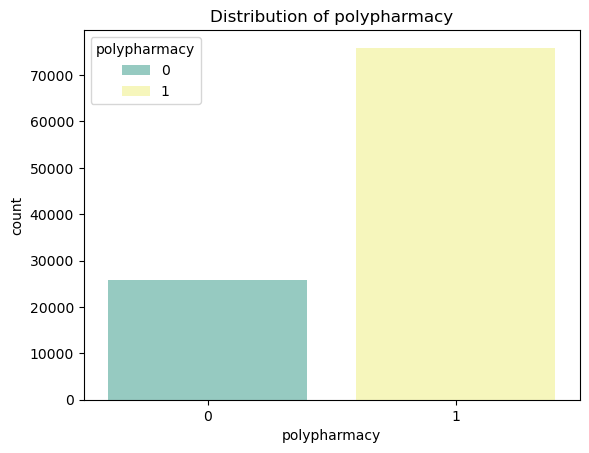

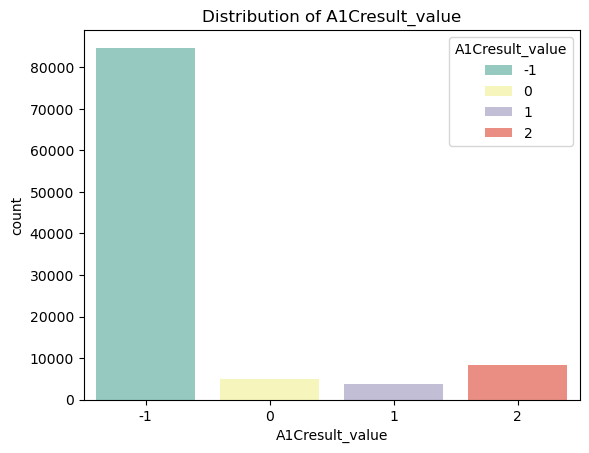

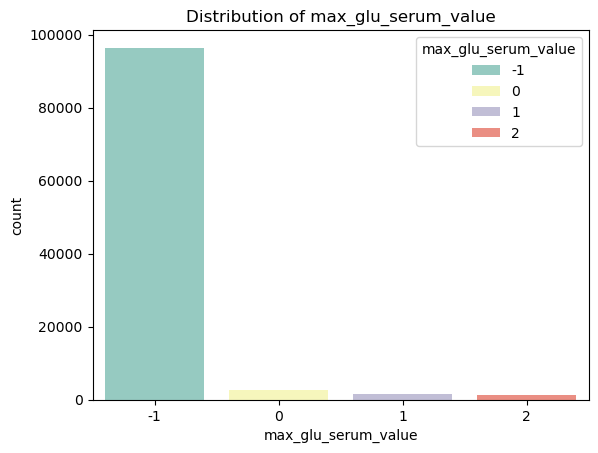

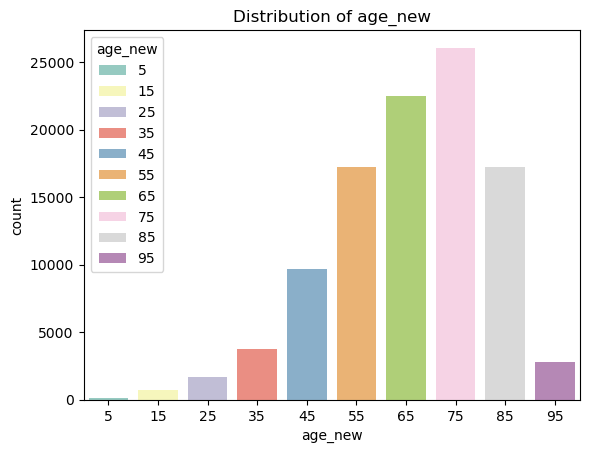

In [66]:
cols = ['polypharmacy', 'A1Cresult_value', 'max_glu_serum_value', 'age_new']
for col in cols:
    sns.countplot(x=col, hue=col, data=data, palette='Set3')
    plt.title(f"Distribution of {col}")
    plt.show()


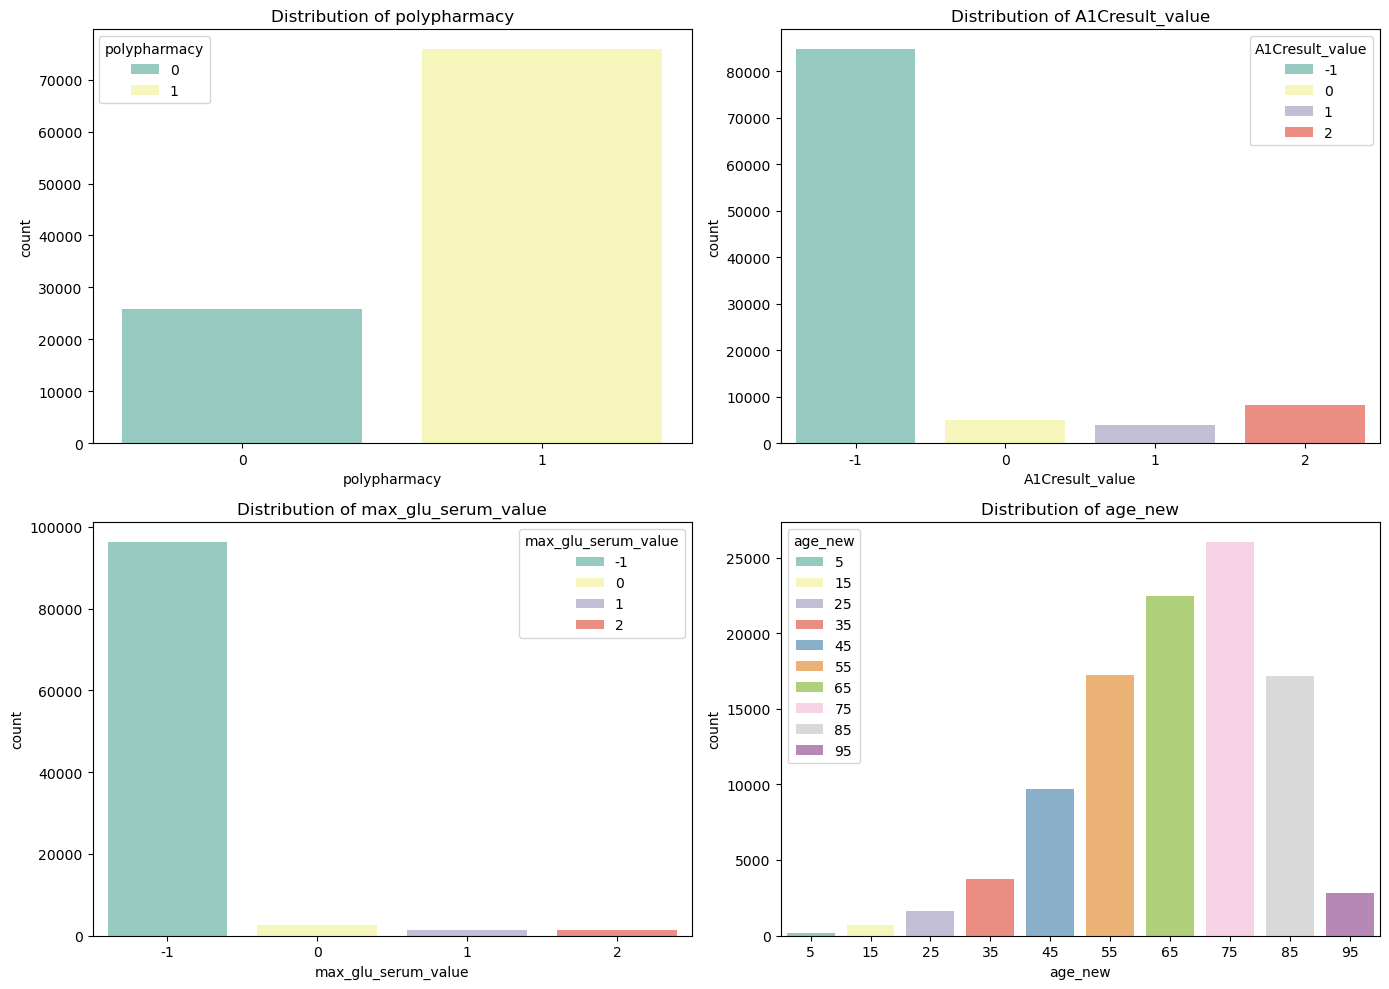

In [67]:

cols = ['polypharmacy', 'A1Cresult_value', 'max_glu_serum_value', 'age_new']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

for ax, col in zip(axes.flatten(), cols):
    sns.countplot(x=col, hue=col, data=data, palette='Set3', ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


#### 6.3 Bivariate Analysis vs Target (cleaned data)

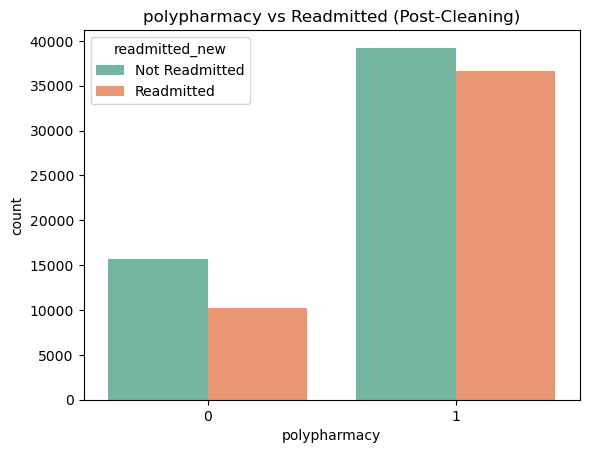

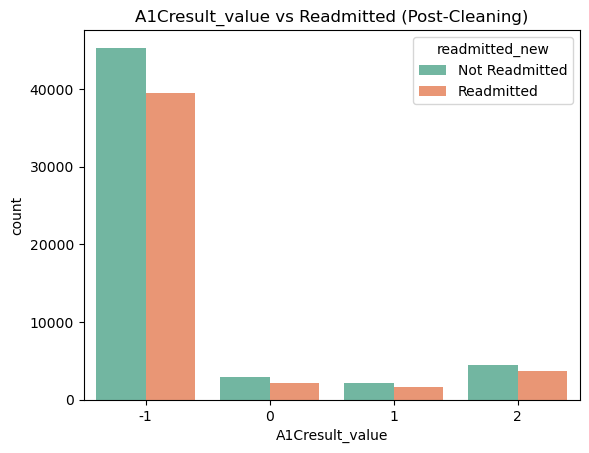

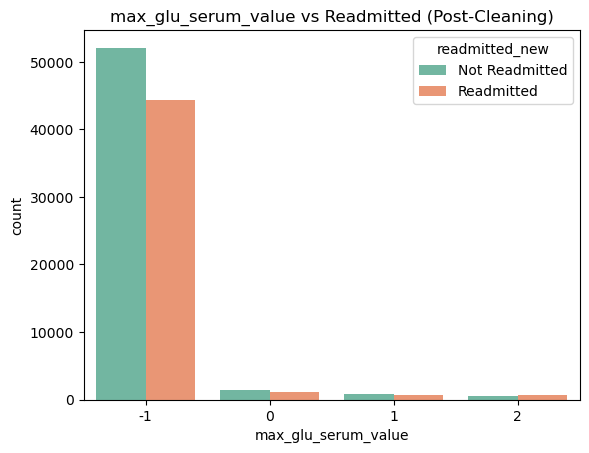

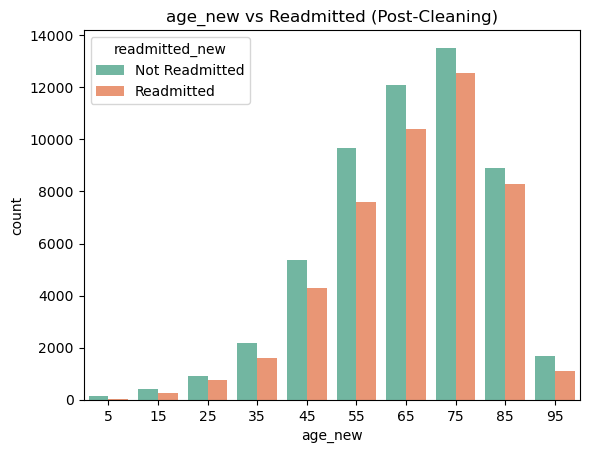

In [69]:
for col in cols:
    sns.countplot(x=col, hue='readmitted_new', data=data, palette='Set2')
    plt.title(f"{col} vs Readmitted (Post-Cleaning)")
    plt.show()


### 6.4 Transformation of Diagnosis Columns 

Figure 5: Transformation of Diagnosis Columns in report

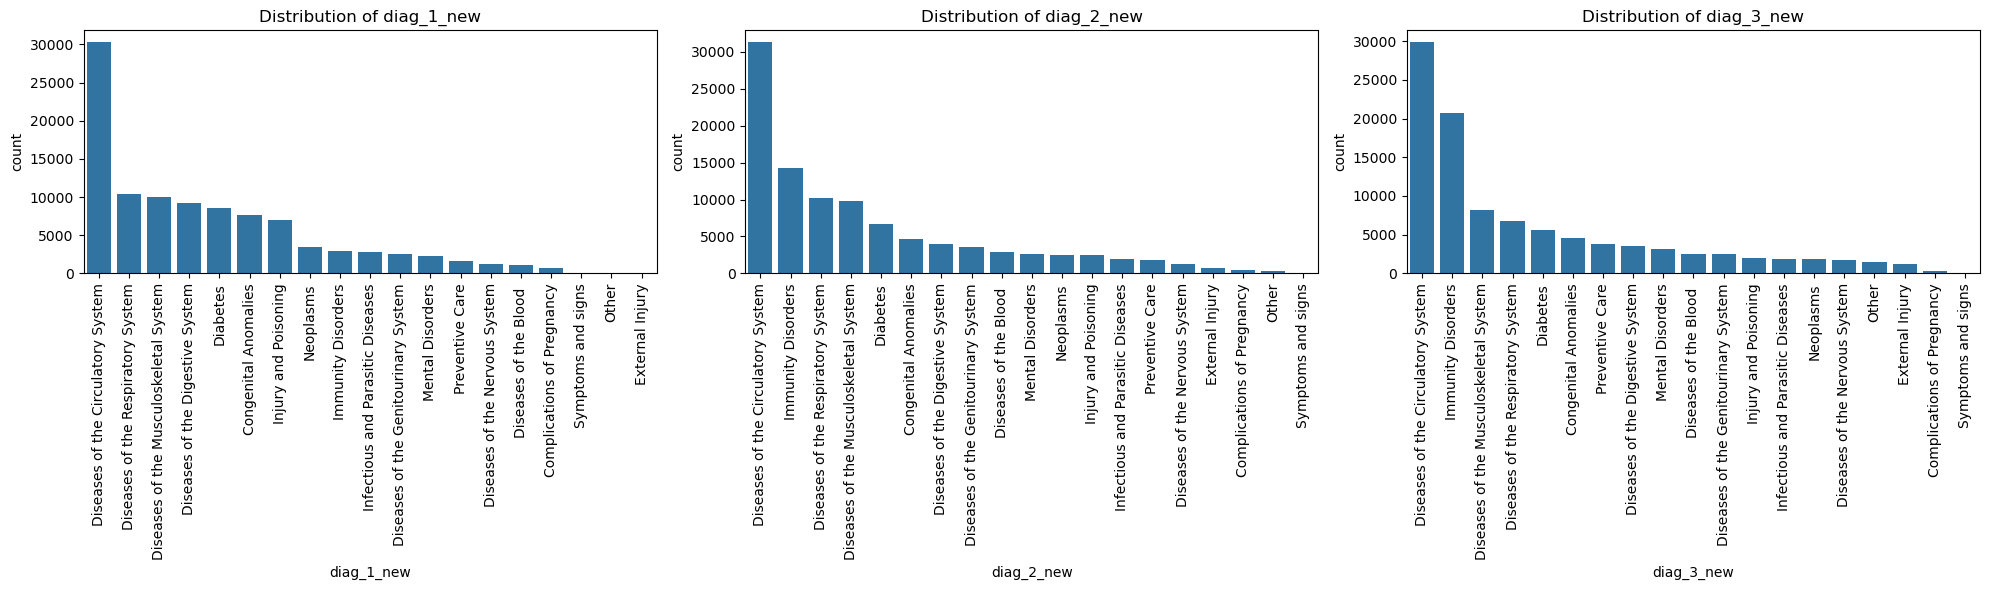

In [71]:

diag_cols = ['diag_1_new', 'diag_2_new', 'diag_3_new']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, col in zip(axes, diag_cols):
    sns.countplot(ax=ax, data=data, x=col, order=data[col].value_counts().index)
    ax.set_title(f'Distribution of {col}')
    ax.tick_params(axis='x', rotation=90) 
    
plt.tight_layout()
plt.show()


#### 6.5 Correlation Heatmap (Post-Cleaning)
Figure 6: Heatmap of numeric variables (Cleaned) in report

In [73]:
final_numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_diagnoses', 'total_visits', 
    'age_new', 'polypharmacy'
]


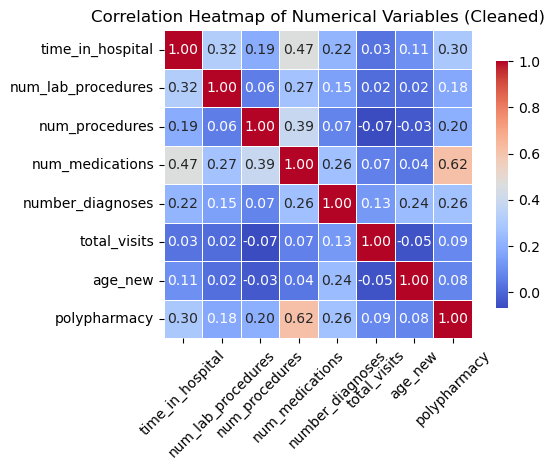

In [74]:
corr_matrix = data[final_numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Variables (Cleaned)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 7 Feature Selection 

#### 7.1 Chi-squared Test for Categorical Variables

In [77]:

# Step 1: Chi-squared Test
def chi_squared_test(data, cat_cols, target):
    # Encode categorical columns
    le = LabelEncoder()
    data_encoded = data[cat_cols].apply(lambda col: le.fit_transform(col.astype(str)))

    # Perform Chi-squared test
    chi2_stats, p_vals = chi2(data_encoded, data[target])

    # Prepare output dataframe
    chi2_df = pd.DataFrame({
        'Feature': cat_cols,
        'Chi2_Stat': chi2_stats,
        'p_value': p_vals
    }).sort_values(by='p_value')

    return chi2_df


categorical_columns = [
    'race', 'gender', 'age', 'weight', 'discharge_disposition_id', 
    'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 
    'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 
    'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide_metformin', 
    'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_pioglitazone', 'change', 
    'diabetesMed', 'readmitted', 'readmitted_new', 'diag_1_new', 'diag_2_new', 
    'diag_3_new'
]
chi2_results = chi_squared_test(data, categorical_columns, target='readmitted_new')
print(chi2_results)


                     Feature     Chi2_Stat        p_value
37            readmitted_new  54861.000000   0.000000e+00
36                readmitted   8821.663605   0.000000e+00
9                     diag_3    828.141731  4.108401e-182
7                     diag_1    646.525350  1.272864e-142
40                diag_3_new    627.690814  1.588728e-138
5        admission_source_id    429.703116   1.885840e-95
39                diag_2_new    295.736138   2.797339e-66
3                     weight    193.374501   5.831543e-44
38                diag_1_new    145.233400   1.909563e-33
34                    change    115.960646   4.848224e-27
35               diabetesMed     88.522964   5.024815e-21
8                     diag_2     48.312414   3.634441e-12
4   discharge_disposition_id     39.890739   2.685736e-10
2                        age     39.232846   3.761587e-10
0                       race     25.318691   4.859766e-07
1                     gender     17.737037   2.536399e-05
12            

#### 7.2 VIF Check for Multicollinearity (Numerical Variables)

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 2: VIF Check
def calculate_vif(data, num_cols):
    X = data[num_cols].copy()
    X = X.assign(Intercept=1)  # Add intercept for statsmodels compatibility

    vif_df = pd.DataFrame()
    vif_df["Feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_df.sort_values(by='VIF', ascending=False)

# Example usage:
numeric_columns = [
    'encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 
    'number_inpatient', 'number_diagnoses', 'age_new','max_glu_serum_value', 
    'polypharmacy', 'total_visits', 'A1Cresult_value'
]
vif_results = calculate_vif(data, numeric_columns)
print(vif_results)


C:\Users\gayu4\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                Feature        VIF
6     number_outpatient        inf
7      number_emergency        inf
8      number_inpatient        inf
13         total_visits        inf
15            Intercept  34.364703
5       num_medications   2.150220
12         polypharmacy   1.648681
0          encounter_id   1.460469
2      time_in_hospital   1.404169
1           patient_nbr   1.382478
9      number_diagnoses   1.288118
3    num_lab_procedures   1.245441
4        num_procedures   1.209414
10              age_new   1.115534
14      A1Cresult_value   1.096770
11  max_glu_serum_value   1.058404


# 8 Handling outliers 

#### 8.1 Dropping Columns
Based on Chi square stats and VIF Check dropping unwanted columns

In [82]:
drop_col = ['glipizide','metformin', 'glipizide_metformin', 'acetohexamide', 
                  'pioglitazone', 'rosiglitazone', 'troglitazone', 'tolazamide', 'metformin_pioglitazone', 
                  'repaglinide', 'max_glu_serum', 'A1Cresult', 'glimepiride', 'tolbutamide',
                  'glyburide', 'acarbose', 'insulin', 'nateglinide','glyburide_metformin', 'chlorpropamide',
                  'miglitol','number_inpatient', 'number_outpatient', 'number_emergency', 'diag_1', 'diag_2', 'diag_3',
                  'age', 'weight','examide', 'citoglipton', 'readmitted','encounter_id', 'patient_nbr', 'glimepiride_pioglitazone']
data = data.drop(drop_col, axis=1)

#### 8.2 Performing Interquartile range


In [84]:
iqr = ['time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_diagnoses', 'total_visits', 
            'age_new', 'A1Cresult_value', 'max_glu_serum_value']


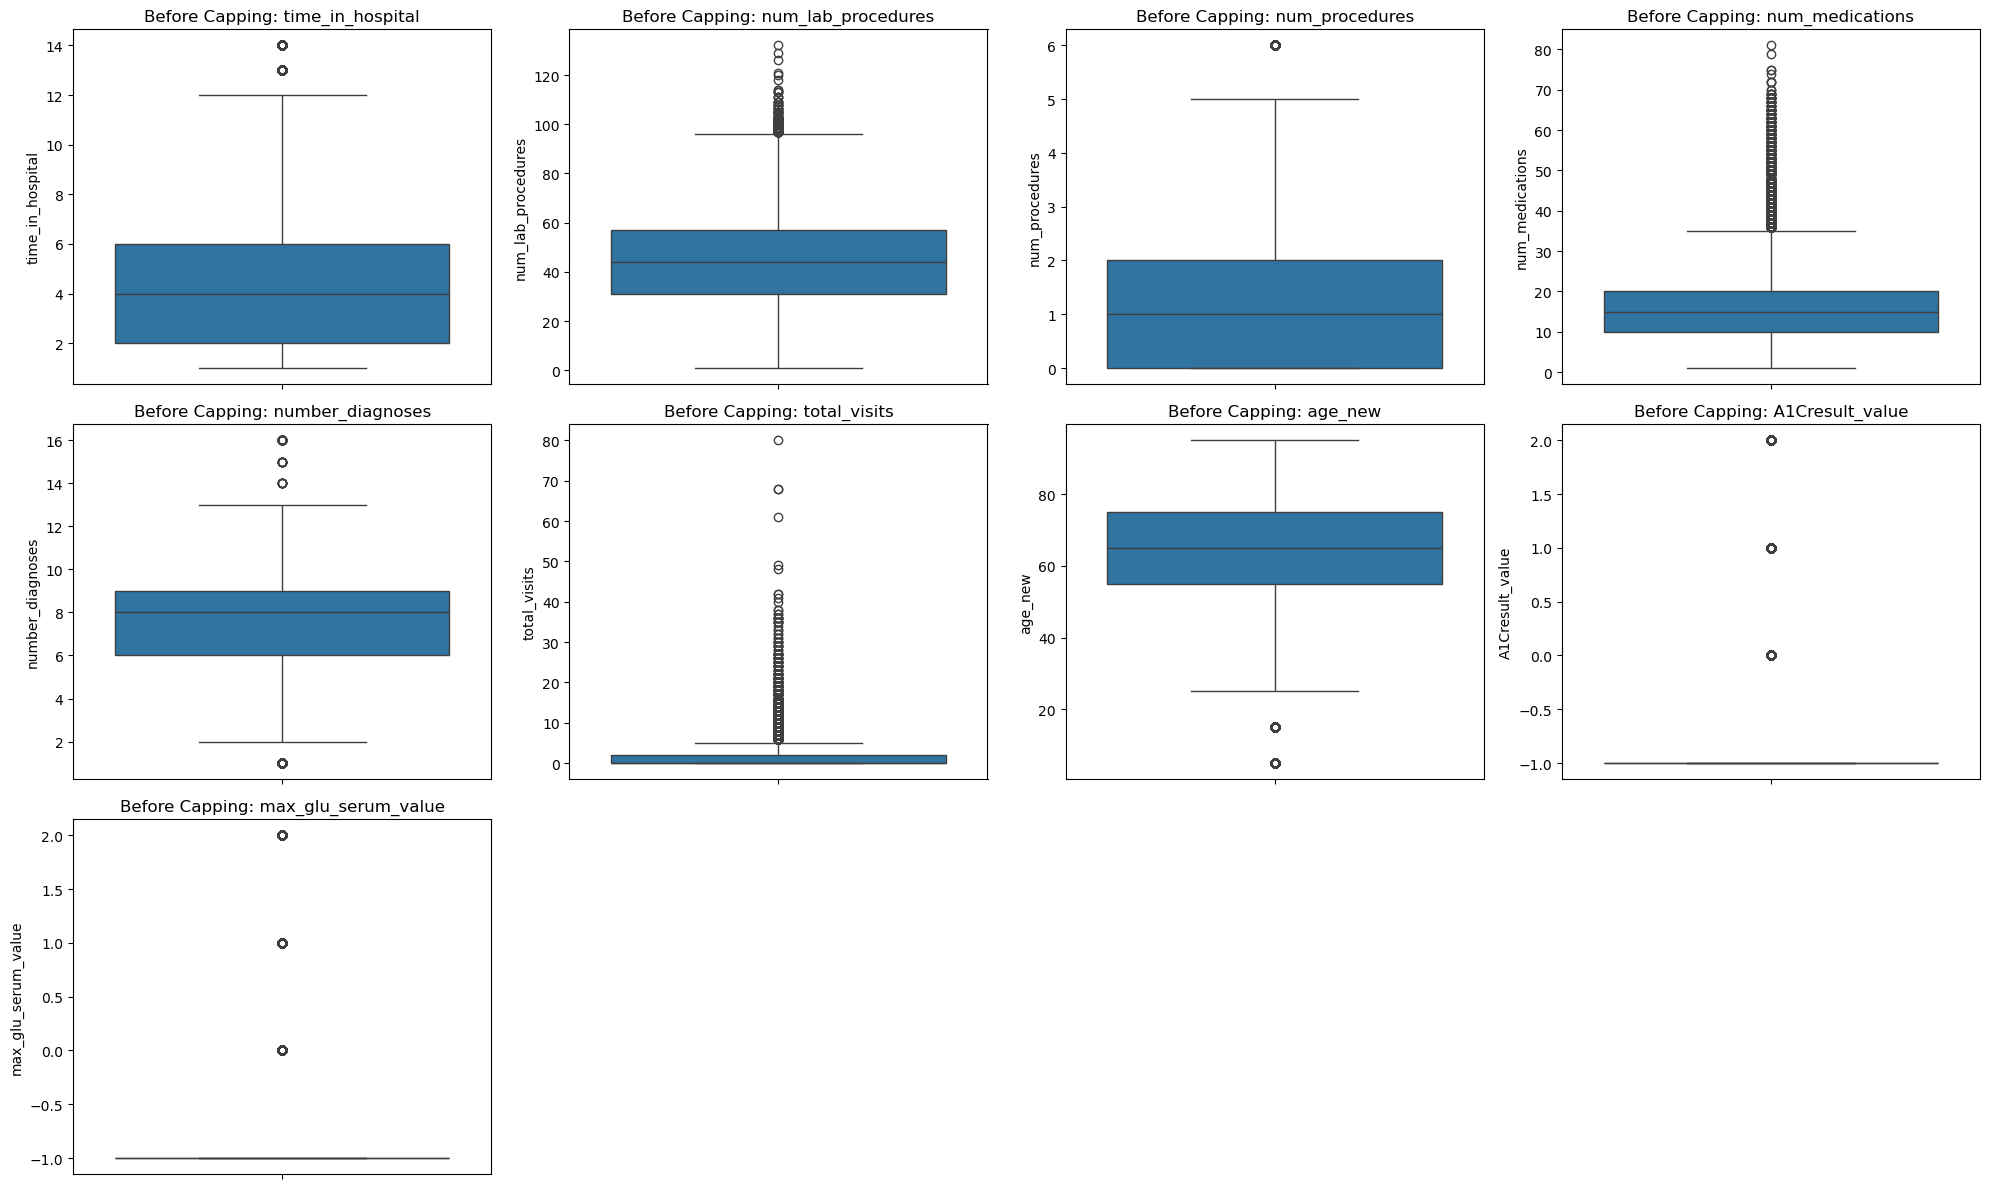

In [85]:
plt.figure(figsize=(20, 12))
for idx, col in enumerate(iqr):
    plt.subplot(3, 4, idx + 1)
    sns.boxplot(y=data[col])
    plt.title(f"Before Capping: {col}")
plt.tight_layout()
plt.show()

In [86]:
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

        print(f"{col}: Outliers capped at [{lower_bound:.2f}, {upper_bound:.2f}]")
    return df

data = cap_outliers_iqr(data, iqr)

time_in_hospital: Outliers capped at [-4.00, 12.00]
num_lab_procedures: Outliers capped at [-8.00, 96.00]
num_procedures: Outliers capped at [-3.00, 5.00]
num_medications: Outliers capped at [-5.00, 35.00]
number_diagnoses: Outliers capped at [1.50, 13.50]
total_visits: Outliers capped at [-3.00, 5.00]
age_new: Outliers capped at [25.00, 105.00]
A1Cresult_value: Outliers capped at [-1.00, -1.00]
max_glu_serum_value: Outliers capped at [-1.00, -1.00]


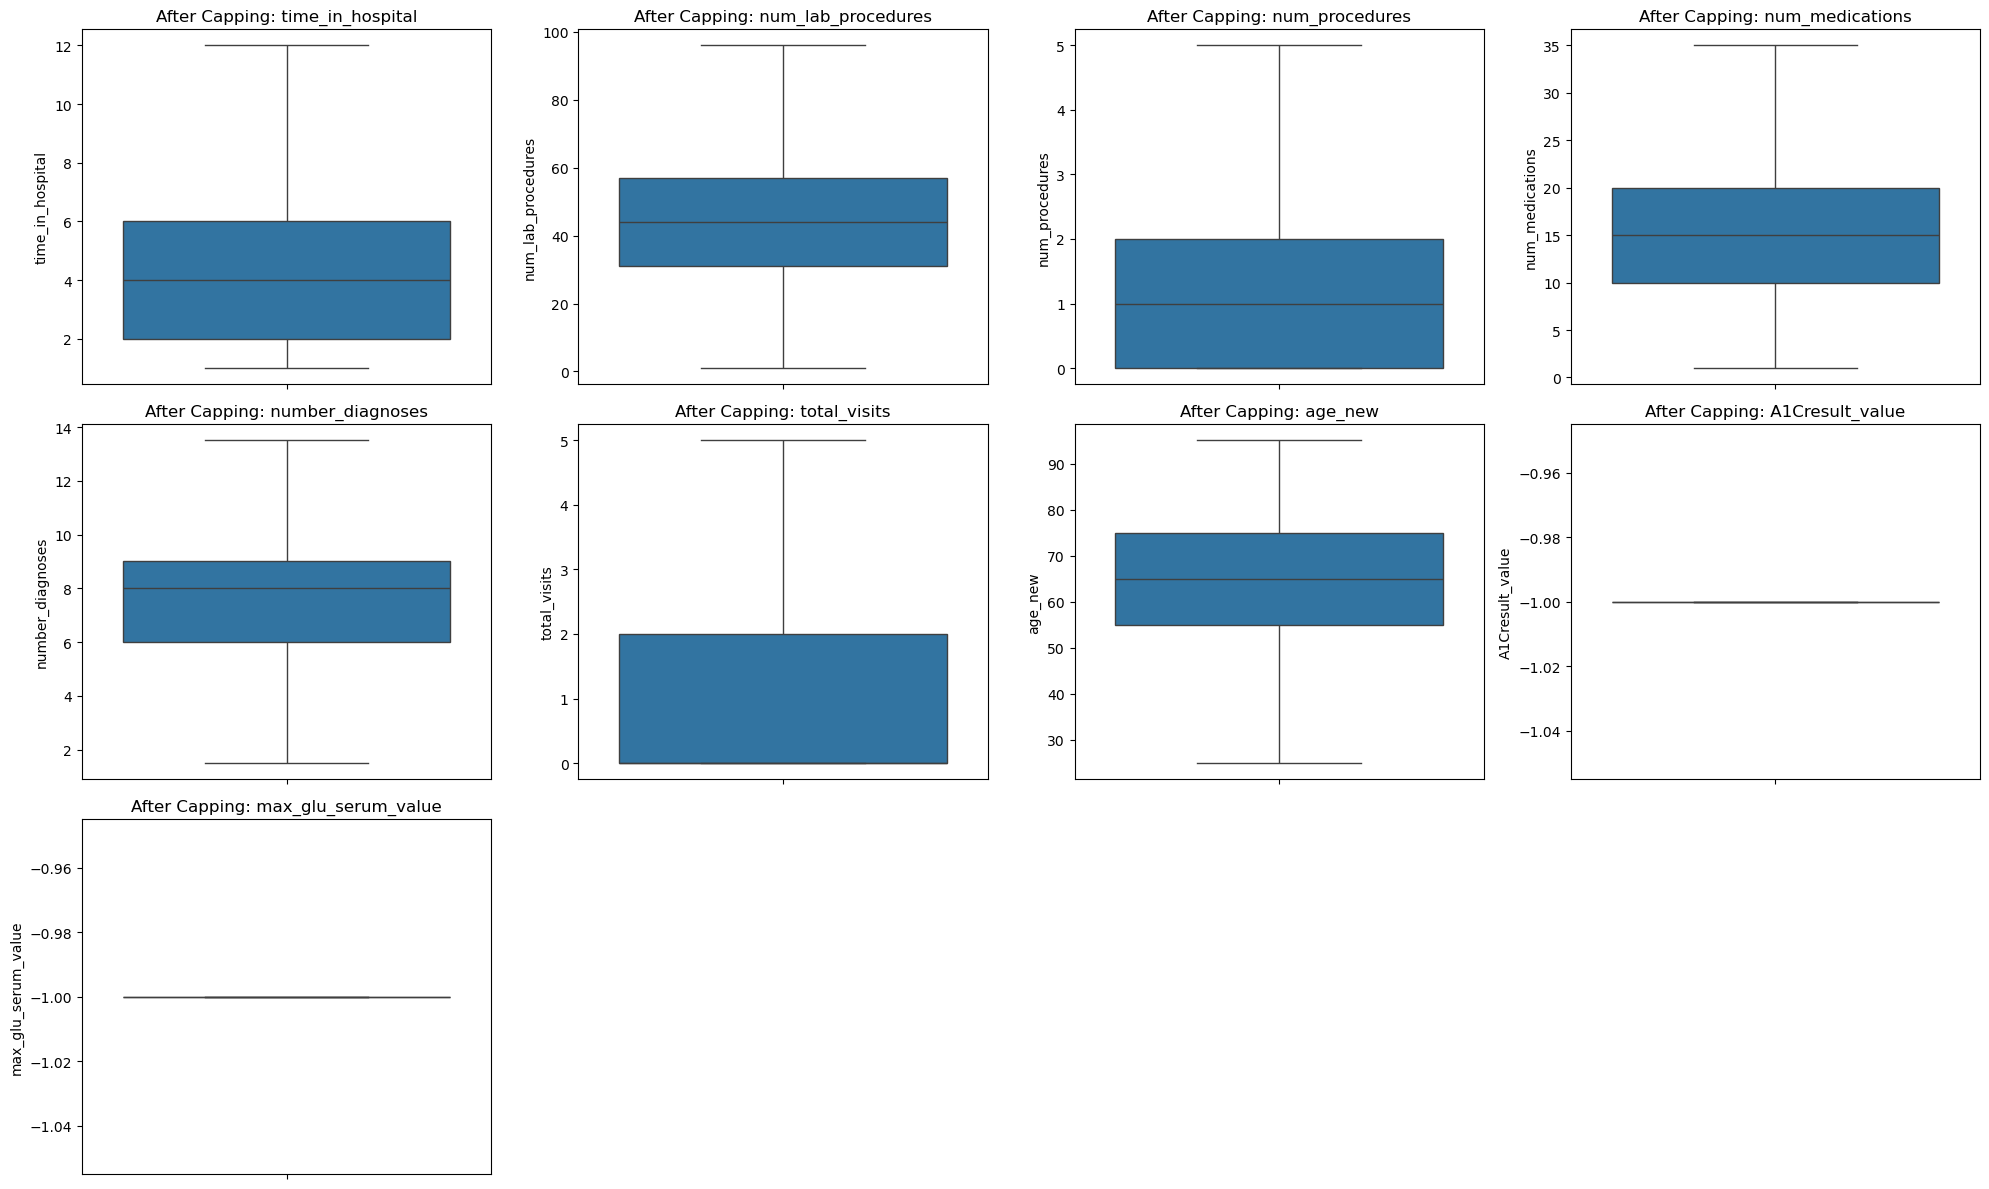

In [87]:
plt.figure(figsize=(20, 12))
for idx, col in enumerate(iqr):
    plt.subplot(3, 4, idx + 1)
    sns.boxplot(y=data[col])
    plt.title(f"After Capping: {col}")
plt.tight_layout()
plt.show()

# 9 Preprocessing Pipeline

In [89]:
print(data.shape)
print(data.columns)

(101763, 21)
Index(['race', 'gender', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_diagnoses', 'change',
       'diabetesMed', 'readmitted_new', 'diag_1_new', 'diag_2_new',
       'diag_3_new', 'age_new', 'A1Cresult_value', 'max_glu_serum_value',
       'total_visits', 'polypharmacy'],
      dtype='object')


### 9.1 Defining columns

In [91]:

# Numeric columns to scale
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_diagnoses', 'total_visits', 
    'age_new', 'A1Cresult_value', 'max_glu_serum_value']

# Categorical columns to one-hot encode
categorical_cols = ['race', 'gender', 'discharge_disposition_id', 'admission_source_id','medical_specialty', 'diag_1_new', 'diag_2_new', 'diag_3_new',
    'change', 'diabetesMed']

# Features to passthrough (binary columns)
binary_cols = ['polypharmacy']


In [92]:
desc_stats = data[numeric_cols].describe().T.round(2)
print("Statistical Summary".center(80))
print(desc_stats)

                              Statistical Summary                               
                        count   mean    std   min   25%   50%   75%   max
time_in_hospital     101763.0   4.36   2.89   1.0   2.0   4.0   6.0  12.0
num_lab_procedures   101763.0  43.09  19.65   1.0  31.0  44.0  57.0  96.0
num_procedures       101763.0   1.29   1.58   0.0   0.0   1.0   2.0   5.0
num_medications      101763.0  15.81   7.40   1.0  10.0  15.0  20.0  35.0
number_diagnoses     101763.0   7.42   1.93   1.5   6.0   8.0   9.0  13.5
total_visits         101763.0   1.03   1.49   0.0   0.0   0.0   2.0   5.0
age_new              101763.0  66.07  15.64  25.0  55.0  65.0  75.0  95.0
A1Cresult_value      101763.0  -1.00   0.00  -1.0  -1.0  -1.0  -1.0  -1.0
max_glu_serum_value  101763.0  -1.00   0.00  -1.0  -1.0  -1.0  -1.0  -1.0


#### 9.2 Building ColumnTransformer 
Applying 
- StandardScaler on Numeric Columns 
- One Hot Encoding on categorical Columns 

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),         # Standardize numeric features
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),  # OHE categorical
        ('bin', 'passthrough', binary_cols)              # Keep binary features as-is
    ]
)


# 10  Model Training

In [96]:
data["readmitted_new"] = data["readmitted_new"].apply(lambda x: 1 if x == "Readmitted" else 0)
data["readmitted_new"].value_counts()

readmitted_new
0    54861
1    46902
Name: count, dtype: int64

In [97]:
X = data.drop(columns=['readmitted_new'])  
y = data['readmitted_new']

In [98]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [99]:
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())

Missing values in X_train: 0
Missing values in X_test: 0


In [100]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### 10.1 Model 1 - Basic Logistic Regression (with class_weight='balanced')

In [102]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')
log_reg.fit(X_train_processed, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

### Model 2 - L2-Regularized Logistic Regression (using saga solver)

In [104]:
log_reg_l2_saga = LogisticRegression(
    penalty='l2',
    solver='saga',
    class_weight='balanced',
    max_iter=1000
)

log_reg_l2_saga.fit(X_train_processed, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, solver='saga')

###  Model 3 - ElasticNet

In [106]:
log_reg_en = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
    l1_ratio=0.5,  # Mix between L1 and L2
    max_iter=1000
)

log_reg_en.fit(X_train_processed, y_train)


LogisticRegression(class_weight='balanced', l1_ratio=0.5, max_iter=1000,
                   penalty='elasticnet', solver='saga')

### Model 4 - GridSearch ElasticNet

In [108]:
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
    max_iter=1000
)

In [109]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

In [110]:
grid_search_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [111]:
grid_search_en.fit(X_train_processed, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9]},
             scoring='accuracy', verbose=1)

In [112]:
print("Best Params:", grid_search_en.best_params_)
print("Best CV F1-score:", grid_search_en.best_score_)

Best Params: {'C': 0.1, 'l1_ratio': 0.1}
Best CV F1-score: 0.6226099889200365


# 11. Model Evaluation

In [114]:
models = {
    'Model 1 - Basic Logistic Regression': log_reg,
    'Model 2 - L2 (saga)': log_reg_l2_saga,
    'Model 3 - ElasticNet': log_reg_en,
    'Model 4 - GridSeach ElasticNet': grid_search_en}

results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
    }
    
    # Add ROC AUC if probability scores are available
    if y_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_test, y_proba)
    
    results[name] = metrics

# Convert to DataFrame
metrics_df = pd.DataFrame(results).T

In [115]:

for name, model in models.items():
    try:
        check_is_fitted(model)
        y_pred = model.predict(X_test_processed)
        y_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, "predict_proba") else None
        
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
        }
        
        if y_proba is not None:
            metrics['ROC AUC'] = roc_auc_score(y_test, y_proba)
        
        results[name] = metrics
    except Exception as e:
        print(f"Skipping {name} due to error: {e}")

# Convert to DataFrame
metrics_df = pd.DataFrame(results).T
print(metrics_df.round(3))


                                     Accuracy  Precision  Recall  F1 Score  \
Model 1 - Basic Logistic Regression     0.627      0.604   0.564     0.584   
Model 2 - L2 (saga)                     0.627      0.604   0.565     0.584   
Model 3 - ElasticNet                    0.627      0.604   0.564     0.584   
Model 4 - GridSeach ElasticNet          0.626      0.604   0.562     0.583   

                                     ROC AUC  
Model 1 - Basic Logistic Regression    0.670  
Model 2 - L2 (saga)                    0.670  
Model 3 - ElasticNet                   0.670  
Model 4 - GridSeach ElasticNet         0.669  


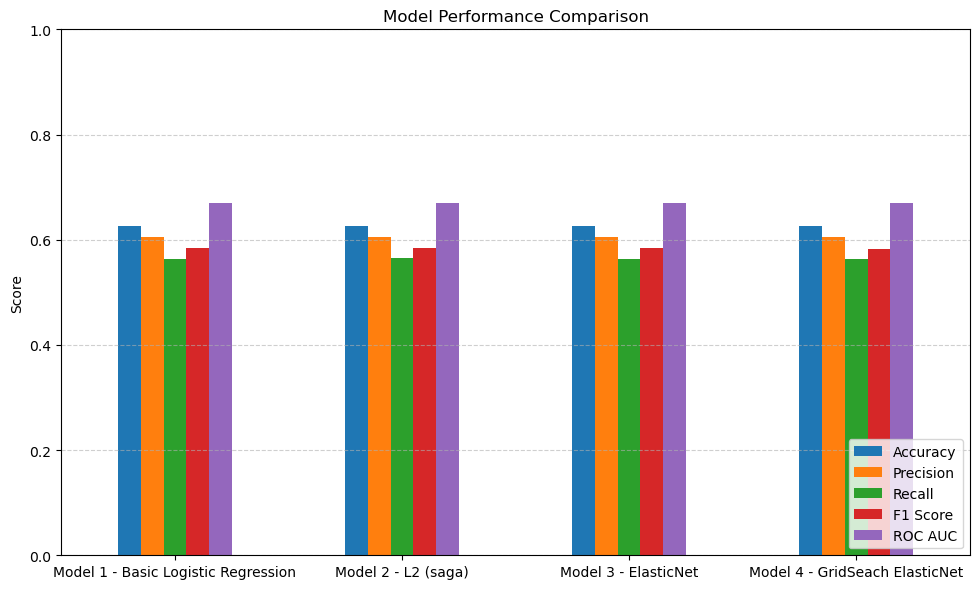

In [116]:
# Plotting
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [188]:
from sklearn.metrics import roc_curve, roc_auc_score

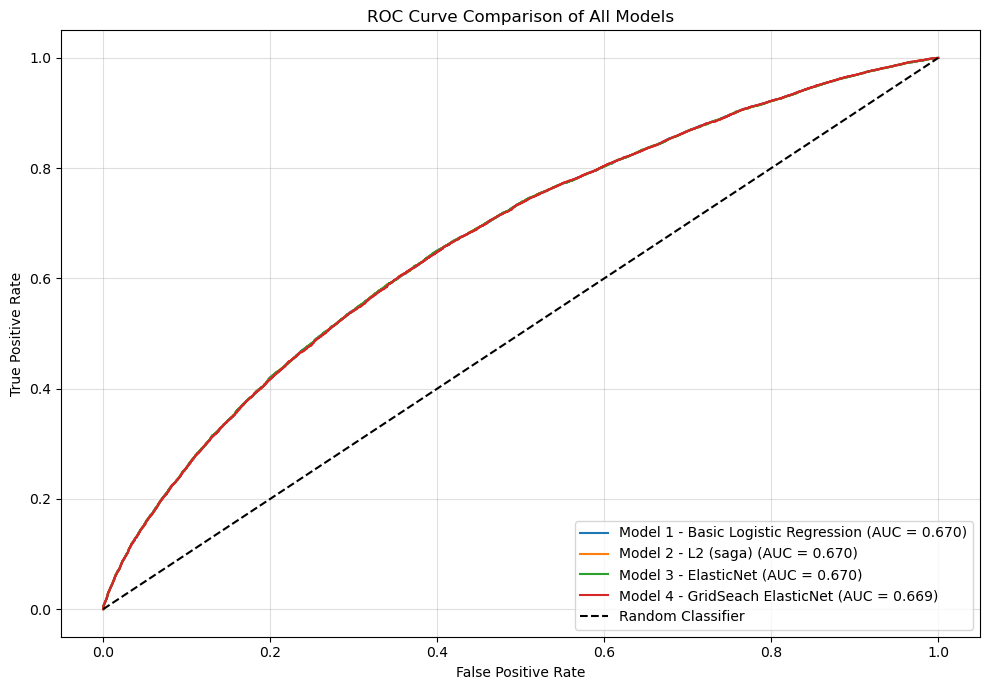

In [190]:
models = {
    'Model 1 - Basic Logistic Regression': log_reg,
    'Model 2 - L2 (saga)': log_reg_l2_saga,
    'Model 3 - ElasticNet': log_reg_en,
    'Model 4 - GridSeach ElasticNet': grid_search_en}

plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Plot the random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.title('ROC Curve Comparison of All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()
